### Setting up the AlH molecule

### Performing FCI calculations by varying H-Al bond length

converged SCF energy = -242.350991941462
Bond length: 1.30 Å, HF Energy: -242.35099194 Hartree, FCI Energy: -242.37895367 Hartree
converged SCF energy = -242.362738358728
Bond length: 1.35 Å, HF Energy: -242.36273836 Hartree, FCI Energy: -242.39115710 Hartree
converged SCF energy = -242.371379639899
Bond length: 1.40 Å, HF Energy: -242.37137964 Hartree, FCI Energy: -242.40035223 Hartree
converged SCF energy = -242.377436653512
Bond length: 1.45 Å, HF Energy: -242.37743665 Hartree, FCI Energy: -242.40706117 Hartree
converged SCF energy = -242.381344362086
Bond length: 1.50 Å, HF Energy: -242.38134436 Hartree, FCI Energy: -242.41172106 Hartree
converged SCF energy = -242.383467436306
Bond length: 1.55 Å, HF Energy: -242.38346744 Hartree, FCI Energy: -242.41469968 Hartree
converged SCF energy = -242.384112762609
Bond length: 1.60 Å, HF Energy: -242.38411276 Hartree, FCI Energy: -242.41630793 Hartree
converged SCF energy = -242.383539508041
Bond length: 1.65 Å, HF Energy: -242.38353951 Har

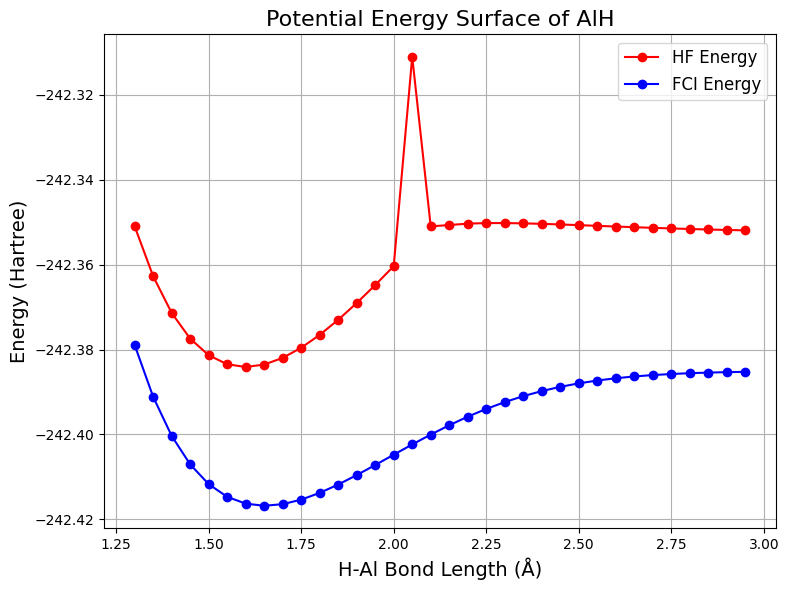

Potential energy surface plot saved to AlH6_structure_FCI/pes_alh_fci.png
Results saved to AlH6_structure_FCI/results_fci.txt


In [1]:
import os
import numpy as np
from pyscf import gto, scf, fci
import matplotlib.pyplot as plt
from ase import Atoms
from ase.io import write
from IPython.display import display, Markdown, Image

# Create a directory to save results
output_dir = 'AlH6_structure_FCI'
os.makedirs(output_dir, exist_ok=True)

# Function to display intermediate steps in Markdown format
def display_step(step_text):
    display(Markdown(f"### {step_text}"))

# Step 1: Define the AlH molecule
display_step("Setting up the AlH molecule")

# Define common parameters for PySCF
charge = 0
spin = 2  # Total spin (2S = 2 for a doublet state)
basis = '6-31g'

# Initialize lists for H-Al bond lengths and energies
bond_lengths = np.arange(1.3, 3.0, 0.05)  # H-Al bond lengths in Ångstroms
hf_energies = []
fci_energies = []

# Step 2: Perform FCI calculations by varying H-Al bond length
display_step("Performing FCI calculations by varying H-Al bond length")

for bond_length in bond_lengths:
    # Define geometry with varying bond length
    geometry = [
        ('Al', (0.0, 0.0, 0.0)),  # Al at origin
        ('H', (0.0, 0.0, bond_length))  # H along the z-axis
    ]
    
    # Create molecule
    mol = gto.M(atom=geometry, basis=basis, charge=charge, spin=spin, unit='angstrom')
    
    # Perform Hartree-Fock calculation (necessary for FCI)
    mf = scf.ROHF(mol)
    mf.conv_tol = 1e-8
    mf.kernel()
    hf_energies.append(mf.e_tot)
    
    # Perform FCI calculation
    cisolver = fci.FCI(mol, mf.mo_coeff)
    e_fci, _ = cisolver.kernel()
    fci_energies.append(e_fci)
    
    print(f"Bond length: {bond_length:.2f} Å, HF Energy: {mf.e_tot:.8f} Hartree, FCI Energy: {e_fci:.8f} Hartree")

# Step 3: Plot the energy vs bond length
plt.figure(figsize=(8, 6))
plt.plot(bond_lengths, hf_energies, marker='o', linestyle='-', color='r', label='HF Energy')
plt.plot(bond_lengths, fci_energies, marker='o', linestyle='-', color='b', label='FCI Energy')
plt.xlabel('H-Al Bond Length (Å)', fontsize=14)
plt.ylabel('Energy (Hartree)', fontsize=14)
plt.title('Potential Energy Surface of AlH', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plot_file = os.path.join(output_dir, 'pes_alh_fci.png')
plt.savefig(plot_file)
plt.show()

print(f"Potential energy surface plot saved to {plot_file}")

# Step 4: Save results to a text file
results_file = os.path.join(output_dir, 'results_fci.txt')
with open(results_file, 'w') as f:
    f.write("H-Al Bond Length (Å)    HF Energy (Hartree)    FCI Energy (Hartree)\n")
    for bond_length, hf_energy, fci_energy in zip(bond_lengths, hf_energies, fci_energies):
        f.write(f"{bond_length:.2f}    {hf_energy:.8f}    {fci_energy:.8f}\n")

print(f"Results saved to {results_file}")


# Generate Molecular hamiltonion for quantum computation

In [1]:
import os
import numpy as np
from pyscf import gto, scf, mcscf
from ase import Atoms
from ase.visualize import view
from ase.io import write  # For saving geometry files
from openfermionpyscf import generate_molecular_hamiltonian
from openfermion.transforms import get_fermion_operator
from openfermion.linalg import eigenspectrum
from openfermion.transforms import jordan_wigner, bravyi_kitaev_tree
from IPython.display import display, Image, Markdown
# Qiskit imports
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2
from qiskit.primitives import StatevectorEstimator as Estimator, StatevectorSampler as Sampler
from pyscf import gto, scf, fci

from openfermion.linalg import get_sparse_operator  # Updated import for sparse operator conversion
import py3Dmol  # For molecule visualization

# Notebook setup
from IPython.display import display, Markdown

# Create a directory to save results
output_dir = 'AlH_150'
os.makedirs(output_dir, exist_ok=True)

# Function to display intermediate steps in Markdown format
def display_step(step_text):
    display(Markdown(f"### {step_text}"))

# Step 1: Define the AlH molecule geometry and basis set
display_step("Step 1: Define the AlH molecule geometry and basis set")
geometry = [('Al', (0, 0, 0)), ('H', (0, 0, 1.50))]  # Bond distance ~1.30 Å
basis = 'sto-3g'  # Minimal basis set
multiplicity = 3  # Triplet state (spin = 2 * multiplicity - 1)
charge = 0  # Neutral AlH molecule
spin = multiplicity - 1  # For triplet, spin = 2

display_step(f"Defined geometry: {geometry}\nUsing basis: {basis}")

# Step 5: Setup molecule and SCF calculation in PySCF
mol = gto.M(atom=geometry, basis=basis, charge=charge, spin=spin, unit='angstrom')
mf = scf.RHF(mol).run()

# Perform FCI calculation
cisolver = fci.FCI(mol, mf.mo_coeff)
e_fci, _ = cisolver.kernel()

# Initialize list to store FCI energies (if required for later computations)
fci_energies = [e_fci]

# Print results
print(f"Bond length: {geometry[1][1][2]:.2f} Å, HF Energy: {mf.e_tot:.8f} Hartree, FCI Energy: {e_fci:.8f} Hartree")


### Step 1: Define the AlH molecule geometry and basis set

### Defined geometry: [('Al', (0, 0, 0)), ('H', (0, 0, 1.5))]
Using basis: sto-3g

converged SCF energy = -239.396795582925
Bond length: 1.50 Å, HF Energy: -239.39679558 Hartree, FCI Energy: -239.42356697 Hartree


In [2]:
# Step 5: Generate the Fermionic Hamiltonian for the subset using OpenFermion

display_step("Step 5: Generate the Fermionic Hamiltonian for the subset of orbitals")

multiplicity = 3
ncas = 5  # Number of active orbitals
nelecas = 4  # Number of active electrons

# Convert molecular integrals to OpenFermion format
molecular_hamiltonian = generate_molecular_hamiltonian(
    geometry=geometry, 
    basis=basis, 
    multiplicity=multiplicity, 
    charge=charge, 
    n_active_electrons=nelecas, 
    n_active_orbitals=ncas
)

# Convert the molecular Hamiltonian to a FermionOperator
fermionic_hamiltonian = get_fermion_operator(molecular_hamiltonian)


# Write the fermionic Hamiltonian to a text file
hamiltonian_file = os.path.join(output_dir, 'active_fermionic_hamiltonian.txt')
with open(hamiltonian_file, 'w') as f:
    f.write(str(fermionic_hamiltonian))
    
display_step(f"Fermionic Hamiltonian written to '{hamiltonian_file}'")


### Step 5: Generate the Fermionic Hamiltonian for the subset of orbitals

### Fermionic Hamiltonian written to 'AlH_150/active_fermionic_hamiltonian.txt'

In [3]:
import os
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev_tree
from openfermion.linalg import eigenspectrum

# Step 6: Transform the Hamiltonian using Jordan-Wigner and Bravyi-Kitaev transformations

# File path for the FermionOperator
fermionic_hamiltonian_file = os.path.join(output_dir, 'active_fermionic_hamiltonian.txt')

# Function to read the FermionOperator from a file
def read_fermion_hamiltonian(file_path):
    with open(file_path, 'r') as file:
        fermion_hamiltonian_str = file.read()
    # Convert the string representation back to FermionOperator
    fermion_hamiltonian = FermionOperator(fermion_hamiltonian_str)
    return fermion_hamiltonian

# Function to manually compute the Hermitian conjugate of a QubitOperator
def hermitian_conjugate(qubit_operator):
    conjugate_operator = QubitOperator()
    for term, coefficient in qubit_operator.terms.items():
        # Conjugate the coefficient (complex conjugate) and add the reversed term
        conjugated_coefficient = coefficient.conjugate()
        conjugate_operator += QubitOperator(term, conjugated_coefficient)
    return conjugate_operator

# Function to enforce Hermiticity by symmetrizing the Hamiltonian
def make_hermitian(qubit_operator):
    # The Hermitian operator is (H + H†) / 2
    hermitian_hamiltonian = (qubit_operator + hermitian_conjugate(qubit_operator)) / 2
    return hermitian_hamiltonian

# Read the fermionic Hamiltonian from the file
fermion_hamiltonian = read_fermion_hamiltonian(fermionic_hamiltonian_file)

# Apply the Jordan-Wigner transformation
jw_hamiltonian = jordan_wigner(fermion_hamiltonian)

# Ensure the Jordan-Wigner Hamiltonian is Hermitian
jw_hamiltonian = make_hermitian(jw_hamiltonian)

# Write the Jordan-Wigner Hamiltonian to a file
jw_hamiltonian_file = os.path.join(output_dir, 'jwh.txt')
with open(jw_hamiltonian_file, 'w') as f:
    f.write(str(jw_hamiltonian))

# Apply the Bravyi-Kitaev transformation
bk_hamiltonian = bravyi_kitaev_tree(fermion_hamiltonian)

# Ensure the Bravyi-Kitaev Hamiltonian is Hermitian
bk_hamiltonian = make_hermitian(bk_hamiltonian)

# Write the Bravyi-Kitaev Hamiltonian to a file
bk_hamiltonian_file = os.path.join(output_dir, 'bkh.txt')
with open(bk_hamiltonian_file, 'w') as f:
    f.write(str(bk_hamiltonian))


In [1]:
import os
from pyscf import gto, scf, mcscf
from openfermionpyscf import generate_molecular_hamiltonian
from openfermion.transforms import jordan_wigner, bravyi_kitaev_tree
from openfermion.transforms import get_fermion_operator
from IPython.display import display, Markdown
from openfermion.ops import FermionOperator, QubitOperator


# Function to create a directory and save results
def save_results(bond_distance, output_dir, fermion_hamiltonian, jw_transform, bk_transform):
    # Create a folder for the bond distance
    folder_name = os.path.join(output_dir, f"AlH_{int(bond_distance * 100)}")
    os.makedirs(folder_name, exist_ok=True)

    # Save fermionic Hamiltonian
    with open(os.path.join(folder_name, "fermionic_hamiltonian.txt"), "w") as f:
        f.write(str(fermion_hamiltonian))

    # Save Jordan-Wigner transformation
    with open(os.path.join(folder_name, "jordan_wigner.txt"), "w") as f:
        f.write(str(jw_transform))

    # Save Bravyi-Kitaev transformation
    with open(os.path.join(folder_name, "bravyi_kitaev.txt"), "w") as f:
        f.write(str(bk_transform))

    print(f"Results saved in folder: {folder_name}")


# Function to manually compute the Hermitian conjugate of a QubitOperator
def hermitian_conjugate(qubit_operator):
    conjugate_operator = QubitOperator()
    for term, coefficient in qubit_operator.terms.items():
        # Conjugate the coefficient (complex conjugate) and add the reversed term
        conjugated_coefficient = coefficient.conjugate()
        conjugate_operator += QubitOperator(term, conjugated_coefficient)
    return conjugate_operator

# Function to enforce Hermiticity by symmetrizing the Hamiltonian
def make_hermitian(qubit_operator):
    # The Hermitian operator is (H + H†) / 2
    hermitian_hamiltonian = (qubit_operator + hermitian_conjugate(qubit_operator)) / 2
    return hermitian_hamiltonian


# Function to perform calculations for a given bond distance
def calculate_and_save(bond_distance, output_dir, active_electrons, active_orbitals):
    display(Markdown(f"### Processing bond distance: {bond_distance} Å"))

    # Define molecule geometry
    geometry = [('Al', (0, 0, 0)), ('H', (0, 0, bond_distance))]
    basis = 'sto-3g'
    charge = 0
    multiplicity = 3
    spin = multiplicity - 1

    # Setup molecule and perform SCF calculation
    mol = gto.M(atom=geometry, basis=basis, charge=charge, spin=spin, unit='angstrom')
    mf = scf.RHF(mol).run()

    # Perform CASCI calculation to define active space
    mc = mcscf.CASCI(mf, active_orbitals, active_electrons)
    mc.kernel()

    print(f"Bond distance: {bond_distance:.2f} Å, HF Energy: {mf.e_tot:.8f} Hartree, CASCI Energy: {mc.e_tot:.8f} Hartree")

    # Generate molecular Hamiltonian in full space
    molecular_hamiltonian = generate_molecular_hamiltonian(
        geometry=geometry,
        basis=basis,
        multiplicity=multiplicity,
        charge=charge,
        n_active_electrons=active_electrons,
        n_active_orbitals=active_orbitals

    )
    fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)


    # Apply the Jordan-Wigner transformation
    jw_hamiltonian = jordan_wigner(fermion_hamiltonian)

    # Ensure the Jordan-Wigner Hamiltonian is Hermitian
    jw_hamiltonian = make_hermitian(jw_hamiltonian)

    # Apply the Bravyi-Kitaev transformation
    bk_hamiltonian = bravyi_kitaev_tree(fermion_hamiltonian)

    # Ensure the Bravyi-Kitaev Hamiltonian is Hermitian
    bk_hamiltonian = make_hermitian(bk_hamiltonian)

    # Save results
    save_results(bond_distance, output_dir, fermion_hamiltonian, jw_hamiltonian, bk_hamiltonian)


# Main script
output_dir = "AlH_simulations"
bond_distances = [1.30, 1.35, 1.40, 1.45, 1.50, 1.55, 1.60, 1.65, 1.70, 1.75, 1.80, 1.85, 1.90, 1.95, 2.00, 2.05, 2.10, 2.15, 2.20, 2.25, 2.30, 2.35, 2.35, 2.40, 2.45, 2.50, 2.55, 2.60, 2.65, 2.70, 2.75, 2.80, 2.85, 2.90, 2.95, 3.00]  # Specify bond distances in Å
active_electrons = 4  # Specify the number of active electrons
active_orbitals = 5   # Specify the number of active orbitals

for bond_distance in bond_distances:
    calculate_and_save(bond_distance, output_dir, active_electrons, active_orbitals)


### Processing bond distance: 1.5 Å

converged SCF energy = -239.396795582925
CASCI E = -239.417996712964  E(CI) = -3.23071405837271  S^2 = 2.0000000
Bond distance: 1.50 Å, HF Energy: -239.39679558 Hartree, CASCI Energy: -239.41799671 Hartree
Results saved in folder: AlH_simulations/AlH_150


# Part II 

In [4]:
import os
from qiskit.quantum_info import SparsePauliOp

# Function to read the Hamiltonian from a file
def read_hamiltonian(file_path):
    with open(file_path, 'r') as file:
        hamiltonian = file.read()
    return hamiltonian

# Function to parse the Hamiltonian string and convert it to SparsePauliOp format
def parse_hamiltonian(hamiltonian_string):
    # Remove any newline characters and split the string by " +\n" to get individual terms
    terms = hamiltonian_string.strip().split(" +\n")
    pauli_list = []
    max_qubit_index = 0  # To detect the number of qubits

    for term in terms:
        # Extract the coefficient and operator string
        coeff_part, ops_part = term.split(" [")
        
        # Convert to complex (handling complex parts) and remove imaginary part
        coeff = complex(coeff_part.strip().split("+")[0].strip('()')).real
        
        # Extract the Pauli operators and qubit indices (e.g., 'X0', 'Z1')
        ops = ops_part.strip(']')
        
        # Process the Pauli operators and check the qubit indices
        if ops != "":
            for op in ops.split():
                qubit_index = int(op[1:])  # The qubit index (after the Pauli letter)
                if qubit_index > max_qubit_index:
                    max_qubit_index = qubit_index
        
        pauli_list.append((ops, coeff))

    # The number of qubits is determined by the largest qubit index plus one
    num_qubits = max_qubit_index + 1

    # Build the full Pauli strings for each term
    pauli_terms = []
    for ops, coeff in pauli_list:
        pauli_string = ['I'] * num_qubits  # Initialize as identity for all qubits
        if ops != "":
            for op in ops.split():
                pauli_type = op[0]  # The Pauli operator (X, Y, Z)
                qubit_index = int(op[1:])  # The qubit index
                pauli_string[qubit_index] = pauli_type
        
        # Join the Pauli string to form "ZZII", "XXYY", etc.
        pauli_string = ''.join(pauli_string)
        pauli_terms.append((pauli_string, coeff))

    return pauli_terms, num_qubits

# Define the directory where the file is stored
input_dir = 'AlH_13'
bk_ham_file_path = os.path.join(input_dir, 'bkh.txt')

# Read the Bravyi-Kitaev Hamiltonian from the file
bk_hamiltonian_str = read_hamiltonian(bk_ham_file_path)

# Parse the Bravyi-Kitaev Hamiltonian and detect the number of qubits
pauli_terms, num_qubits = parse_hamiltonian(bk_hamiltonian_str)

# Create the SparsePauliOp from the parsed Pauli terms
hamiltonian = SparsePauliOp.from_list(pauli_terms)

# Output the number of qubits and the Hamiltonian
sparse_ham_file = os.path.join(input_dir, 'sparse_hamiltonian.txt')
with open(sparse_ham_file, 'w') as f:
    f.write(str(hamiltonian))

print(f"Sparse Hamiltonian written to {sparse_ham_file}")


Sparse Hamiltonian written to AlH_13/sparse_hamiltonian.txt


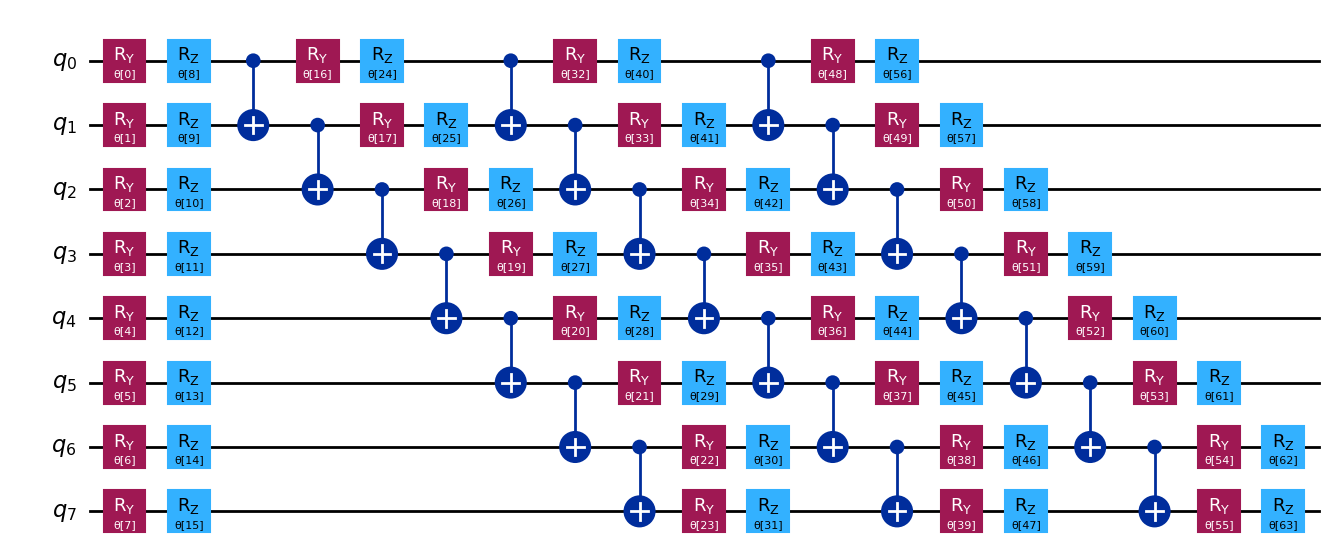

In [5]:
# Change entanglement strategy to 'linear' or 'circular'
ansatz = EfficientSU2(hamiltonian.num_qubits, entanglement='linear')  # Linear entanglement
ansatz.decompose().draw("mpl", style="iqp")


In [7]:
num_params = ansatz.num_parameters

from qiskit_ibm_runtime.fake_provider import FakeSydneyV2

# Run the sampler job locally using FakeManilaV2
fake_paris = FakeSydneyV2()
target = fake_paris.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

# Transpile the ansatz for the backend
ansatz_isa = pm.run(ansatz)


In [9]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

x0 = 2 * np.pi * np.random.random(num_params)



In [11]:
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
estimator = Estimator()
sampler = Sampler()

# SciPy minimizer routine
from scipy.optimize import minimize
import time

start_time = time.time()

res = minimize(cost_func_vqe, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="L-BFGS-B", options={'maxiter': 100, 'disp': True})

end_time = time.time()
execution_time = end_time - start_time

KeyboardInterrupt: 